## Totale N.
### Esercizio 3 punto 1
Alessandro Lodi<br>
Matricola 274425

### Notebook Init

In [1]:
import networkx as nx
import gurobipy as gb
import matplotlib.pyplot as plt
from itertools import combinations, chain
import pygraphviz as pygv
import os
from IPython.display import SVG, display

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class args:
    filename = "atsp04062019R2.gml"
    scale = 40
    figsize = 10,10

In [4]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

### Drawing functions

In [5]:
def DrawInitG(G, withedges=False):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'cost').get('cost') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, x):
    
    plt.figure(figsize=args.figsize)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}

    
    nx.draw_networkx_nodes(G, 
                           pos=pos, 
                           node_shape='o', 
                           node_size=600,
                           node_color='red',
                           label=[G.nodes()])
    
    nx.draw_networkx_labels(G, pos=pos, font_color='w', font_size=12)
    
    for u,v in G.edges():
        if x[u,v].x > 0.01 and x[u,v].x < 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='r')
            
            nx.draw_networkx_edge_labels(G, pos=pos,
                                         edge_labels={(u,v):'{:.2f}'.format(x[u,v].x)})
        
        if x[u,v].x > 0.9:
            nx.draw_networkx_edges(G, pos=pos,
                                   edgelist=[(u,v)],
                                   edge_color='k')
        
    plt.axis('off')
    plt.show()

In [6]:
# Graph reading
basename = os.path.splitext(args.filename)[0]
G = nx.read_graphml (args.filename, node_type=int)
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 27 nodes and 702 edges


In [7]:
G.nodes(data=True)

NodeDataView({1: {'y': 18, 'x': 16}, 2: {'y': 26, 'x': 7}, 3: {'y': 25, 'x': 23}, 4: {'y': 4, 'x': 6}, 10: {'y': 3, 'x': 21}, 6: {'y': 5, 'x': 20}, 7: {'y': 29, 'x': 12}, 8: {'y': 7, 'x': 9}, 9: {'y': 36, 'x': 4}, 5: {'y': 6, 'x': 29}, 11: {'y': 28, 'x': 8}, 12: {'y': 23, 'x': 20}, 13: {'y': 6, 'x': 3}, 14: {'y': 37, 'x': 7}, 15: {'y': 14, 'x': 11}, 16: {'y': 14, 'x': 12}, 17: {'y': 35, 'x': 4}, 18: {'y': 29, 'x': 2}, 19: {'y': 32, 'x': 13}, 22: {'y': 23, 'x': 23}, 21: {'y': 33, 'x': 25}, 20: {'y': 20, 'x': 9}, 23: {'y': 17, 'x': 7}, 24: {'y': 7, 'x': 5}, 25: {'y': 16, 'x': 28}, 26: {'y': 26, 'x': 20}, 27: {'y': 33, 'x': 29}})

## Capacitated Vehicle Routing Problem

>**Given** A fleet of identical vehicles, with limited capacity, located at a depot; $n$ customers that require service with known demand; cost of travel between any pair of customers, or between any customer and the depot.

>**Find** A minimum-cost collection of vehicle routes, each starting and ending at the depot, such that each customer is visited by exactly one vehicle, and no vehicle visits a set of customers whose total demand exceeds the vehicle capacity.

Let $G=(V,A)$ be a directed graph with node $1$ representing the depot and $V_C=V\setminus{1}$ representing the customers.
The (positive integer) demand of customer $i \in V_C$ is denoted by $q_i$.
For any set of customer $S \subset V_C$ let $q(S)=\sum_{i \in S} q_i$.

### Single commodity flow formulation


$$
x_{ij} = \begin{cases}1 \text{ if arc $(i, j)$ is some vehicle travels from $i$ to $j$} \\
0 \text{ otherwise}
\end{cases}
$$


$$
\begin{align}
\min & \sum_{(i,j) \in A} c_{ij} x_{ij} \\
\text{subject}& \text{ to} \\
\sum_{j \in \delta^+(i)} x_{ij} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} x_{ji} & = 1\;\; \forall i \in V_C\\
\sum_{j \in \delta^-(i)} f_{ji} - \sum_{j \in \delta^+(i)} f_{ij} & = q_i \;\;\forall i \in V_C\\
 q_j x_{ij} \le f_{ij} & \le (Q-q_i) x_{ij}  \;\; \forall (i,j) \in A\\
\\
x_{ij} & \in \{0,1\} \;\; \forall(i,j) \in A \\
\end{align}
$$


In [8]:
cvrp = gb.Model()

# Vehicle capacity 
Q = 8 

depots = [1,10,20]

# Node demand
dem = {i:1 for i in G.nodes()}

# Depots does not require service
for depot in depots:
    dem[depot] = 0


x = cvrp.addVars(G.edges(), 
                 obj=[G[i][j]['dist'] for i,j in G.edges()],
                 vtype = gb.GRB.BINARY, name='x')

f = cvrp.addVars (G.edges(), obj=0.0, lb=0,
                  ub=Q, vtype=gb.GRB.CONTINUOUS, name='f')


# Forward/Reverse star
cvrp.addConstrs((x.sum(i,'*') == 1 for i in G.nodes() if i != 1), name='FS')
cvrp.addConstrs((x.sum('*',i) == 1 for i in G.nodes() if i != 1), name='RS')


# Flow constraints
cvrp.addConstrs((f.sum('*',i) - f.sum(i,'*') == dem[i] for i in G.nodes() if i != 1), name='FLOW')


cvrp.addConstrs((f[i,j] <= (Q - dem[i]) * x[i,j] for i,j in G.edges()),name='VUB')
cvrp.addConstrs((f[i,j] >= dem[j] * x[i,j] for i,j in G.edges()),name='VLB')


cvrp.update()
cvrp.write('cvrp.lp')

Academic license - for non-commercial use only - expires 2021-08-02
Using license file /opt/gurobi/gurobi.lic


In [9]:
num_of_goods = len(G.nodes())-3
goods_price = num_of_goods*120
               
cvrp.addConstr(x.sum(1,'*') == 3, name='Root_max_deg')

cvrp.update()

In [10]:
cvrp.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1483 rows, 1404 columns and 5460 nonzeros
Model fingerprint: 0xe34b7359
Variable types: 702 continuous, 702 integer (702 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 104 rows and 26 columns
Presolve time: 0.01s
Presolved: 1379 rows, 1378 columns, 5330 nonzeros
Variable types: 702 continuous, 676 integer (676 binary)

Root relaxation: objective 1.528155e+04, 1073 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 15281.5536    0   40          - 15281.5536      -     -    0s
H    0     0                    23198.000000 15281.5536  34.1%     -    0s
H    0     

Solution:  15529.0


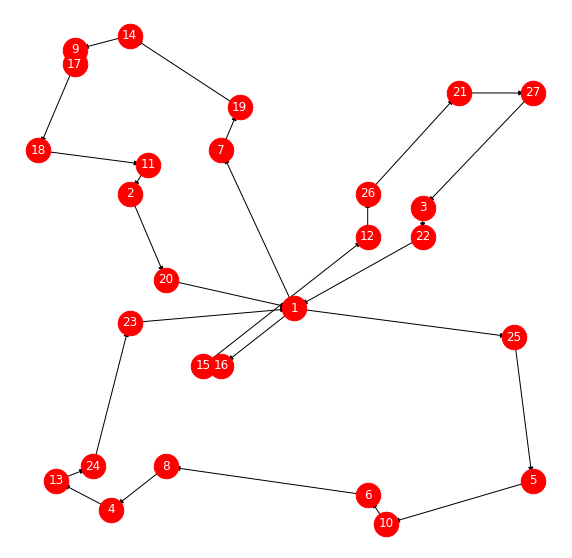

In [11]:
print("Solution: ", cvrp.objVal - goods_price)
DrawSol(G, x)

## Q2

In [12]:
cvrp.addConstr(f.sum('*',18) >= f.sum('*',9)+1  , name='Route_order_18_9')

cvrp.update()

In [13]:
cvrp.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1484 rows, 1404 columns and 5512 nonzeros
Model fingerprint: 0xc5d6872f
Variable types: 702 continuous, 702 integer (702 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 8e+00]
  RHS range        [1e+00, 3e+00]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 104 rows and 26 columns
Presolve time: 0.01s
Presolved: 1380 rows, 1378 columns, 5382 nonzeros
Variable types: 702 continuous, 676 integer (676 binary)

Root relaxation: objective 1.528155e+04, 1114 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 15281.5536    0   41          - 15281.5536      -     -    0s
     0     0 

Solution:  15607.0


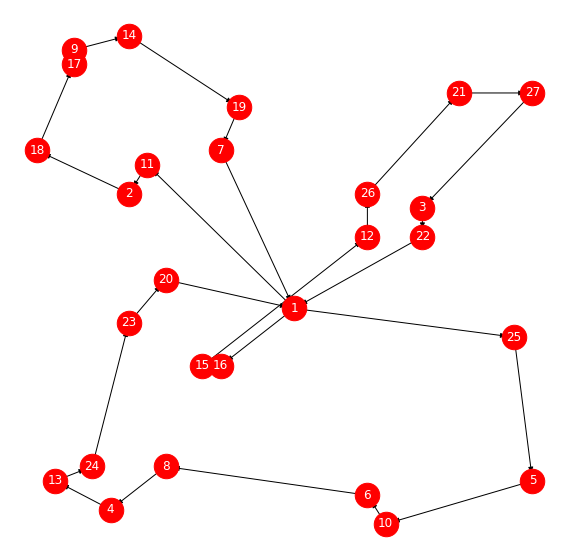

In [14]:
print("Solution: ", cvrp.objVal - goods_price)
DrawSol(G, x)

## Q3

In [15]:
cvrp.remove(cvrp.getConstrByName("Root_max_deg"))
cvrp.remove(cvrp.getConstrByName("Route_order_18_9"))

constrs_to_remove = [const for const in cvrp.getConstrs() if const.ConstrName.startswith('FS') ]
cvrp.remove(constrs_to_remove)
constrs_to_remove = [const for const in cvrp.getConstrs() if const.ConstrName.startswith('RS') ]
cvrp.remove(constrs_to_remove)
constrs_to_remove = [const for const in cvrp.getConstrs() if const.ConstrName.startswith('FLOW') ]
cvrp.remove(constrs_to_remove)

cvrp.update()

In [16]:
# Forward/Reverse star
cvrp.addConstrs((x.sum(i,'*') == 1 for i in G.nodes() if i not in depots), name='FS')
cvrp.addConstrs((x.sum('*',i) == 1 for i in G.nodes() if i not in depots), name='RS')


# Flow constraints
cvrp.addConstrs((f.sum('*',i) - f.sum(i,'*') == dem[i] for i in G.nodes() if i not in depots), name='FLOW')

cvrp.update()

In [17]:
depot_costs = {1:120,10:150,20:200}
    
dg = cvrp.addVars(depots, 
                 obj=[depot_costs[depot] for depot in depots],
                 vtype = gb.GRB.CONTINUOUS, name='dg')

for depot in depots:
    cvrp.addConstr(f.sum(depot,'*') <= dg[depot] ,name='depot_goods_constr')
    
    cvrp.addConstr(x.sum(depot,'*')-x.sum('*',depot) == 0 ,name='vehicle_must_return')
    

cvrp.update()

In [18]:
root = 1

u = cvrp.addVars(G.nodes(), 
                     obj=[0.0 for i in G.nodes()],
                     lb=2.0, ub=G.number_of_nodes(), 
                     vtype=gb.GRB.CONTINUOUS,
                     name='u')

# Fixing root node
u[root].lb = 1.0
u[root].ub = 1.0

cvrp.addConstrs((u[i] - u[j] + (G.number_of_nodes() - 1) * x[i,j] + (G.number_of_nodes() - 3) * x[j,i] <= (G.number_of_nodes() - 2)
                 for i in G.nodes() for j in G.nodes()
                 if (i != j) and (i != root) and (j !=root) and G.has_edge(i,j) and G.has_edge(j,i)), name='MTZ')

cvrp.update()

In [19]:
cvrp.addConstr(u[10] >= u[20]+1  , name='Route_order_10_20')

cvrp.update()

In [20]:
cvrp.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2133 rows, 1434 columns and 8065 nonzeros
Model fingerprint: 0xd2ebf59e
Variable types: 732 continuous, 702 integer (702 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+02, 4e+03]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve did not produce a new incumbent solution

Presolve removed 88 rows and 11 columns
Presolve time: 0.01s
Presolved: 2045 rows, 1423 columns, 7887 nonzeros
Variable types: 722 continuous, 701 integer (701 binary)
Found heuristic solution: objective 69516.000000

Root relaxation: objective 1.825585e+04, 1321 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 18255.8452    0   58 69516.

Solution:  16340.0


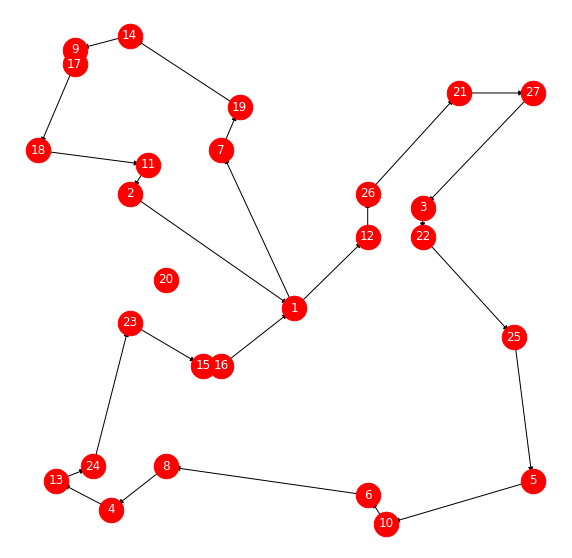

In [21]:
print("Solution: ", cvrp.objVal - goods_price)
DrawSol(G, x)

In [22]:
dg

{1: <gurobi.Var dg[1] (value 16.0)>,
 10: <gurobi.Var dg[10] (value 8.0)>,
 20: <gurobi.Var dg[20] (value 0.0)>}